<a href="https://colab.research.google.com/github/brianosmith/EXSY_fitting_notebook/blob/master/EXSY_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating ZZ-exchange EXSY NMR data

NMR spectroscopy can be used to monitor a wide range of chemical exchange processes on multiple timescales [[1]](https://doi.org/10.1016/S0076-6879(01)39315-1). One useful technique for exchange at relatively slow timescales ($~0.1-10 s^{-1}$) is nD ZZ-exchange EXSY, in which magnetization transfer between states due to exchange is visualized as additional crosspeaks whose intensities depend on the exchange rates between states and the length of the EXSY mixing time.

In this notebook I will explore how to simulate EXSY exchange using Python with the aim of being able to fit experimental data to extract the exchange rates.

## Theory

The evolution of the intensities of the progenitor crosspeaks and exchange crosspeaks in EXSY spectra is given by the following relationship [[2]](https://link.springer.com/protocol/10.1007/978-1-62703-398-5_9#Equ000922)

$$ \begin{bmatrix}I_{P}(T_{mix}) & I_{PL-P}(T_{mix})\\ I_{P-PL}(T_{mix}) & I_{PL}(T_{mix}) \end{bmatrix}= \exp \left( -T_{mix} \begin{bmatrix}k'_{on} + R_{1,P} & -k_{off}\\ -k'_{on} & k_{off} + R_{1,PL} \end{bmatrix} \right) \begin{bmatrix}I_{P}(0) & 0 \\ 0 & I_{PL}(0) \end{bmatrix} $$

Where P and PL refer to the free and bound state of a macromolecule in equilibrium with a ligand

$$P + L \rightleftharpoons PL $$

and $k'_{on}$ is the (pseudo 1st order) association rate ($k_{on}[L]$ for single ligand binding) and $k_{off}$ is the dissociation rate constant while $R_{1} $ are the longditudinal relaxation rates of the magnetization stored on the $z$ axis during $T_{mix}$.

The theory should apply to any system involving exchange between two states.

# Approach
The equation for the evolution of the intensities involves a matrix exponential multiplication of the initial intensities of the form
$$ y(t) = \exp(At) y_0. $$
Computational approaches to solving matrix exponentials are nicely explained here [[3]](https://colab.research.google.com/github/sdrelton/matrix_function_notebooks/blob/master/TheMatrixExponential.ipynb).

As long as the matrix of rate and relaxation constants meets certain criteria, the methods implemented in [scipy.sparse.linalg.expm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.expm.html) [[4]](https://doi.org/10.1137/09074721X) and [scipy.sparse.linalg.expm_multiply](http://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.expm_multiply.html#scipy.sparse.linalg.expm_multiply) [[5]](https://doi.org/10.1137/100788860) should allow efficient calculations.



  


In [0]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.sparse.linalg as la
import matplotlib.pyplot as plt

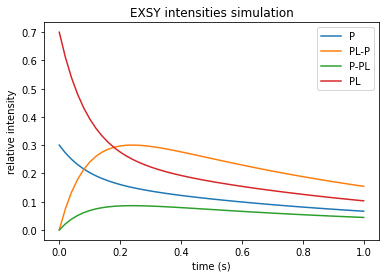

In [0]:
kex = 10.0   # s^{-1}
kon = 4.0    # M * M^{-1}s^{-1} concentration times diffusion limited on rate
koff = kex - kon
R1p = 1.0    # s^{-1}
R1pl = R1p   # keep things simple for now
pa = 0.3
pb = 1 - pa


A = np.array([[kon + R1p, -1.0*koff],
              [-1.0*kon, koff + R1pl]], dtype=np.double)

yzero = np.array([[pa,0],[0,pb]]) # starting intensities/populations

tStart = 0.0
tStop = 1.0        # Tmix up to about 1/R1
nTimes = 51
tval = np.linspace(tStart,tStop,nTimes) # to get a matching time axis for plotting

A = -1.0 * A  # formula is e^{-1*t*A} but expm_multiply() takes A and t
y = la.expm_multiply(A,yzero,tStart,tStop,nTimes,True)

#repr(y[:,0,0])

#plot the results
plt.title("EXSY intensities simulation")
plt.xlabel('time (s)')
plt.ylabel('relative intensity')
plt.plot(tval,y[:,0,0], label='P')
plt.plot(tval,y[:,0,1], label='PL-P')
plt.plot(tval,y[:,1,0], label='P-PL')
plt.plot(tval,y[:,1,1], label='PL')
plt.legend()


## Fitting
We are fitting multiple curves simultaneously, even for one site. Ultimately we will want to fit data from all well resolved signals simultaneously to get a more reliable fit for the common parameters ($k_{on}, k_{off}$) while allowing the site specific parameters ($R_{1,P}, R_{1,PL}$) to vary. The relative populations $p_{PL}/p_{P}$ could be independent parameters if we have enough data but should be available from the ratio of intensities of the respective peaks in a fully relaxed version of the experiments with $T_{mix}=0$ (so constraining $I_{PL}(0)/I_{P}(0)$).

We could try:
https://lmfit.github.io/lmfit-py/examples/example_fit_multi_datasets.html

https://stackoverflow.com/questions/26242979/fit-multiple-parametric-curves-with-scipy

we'll need to define a function that simulates the data

Likely we won't be able to use expm_multiply because our real time series isn't guaranteed to be evenly spaced.

Symfit would seem to be a nice route to manage writing the model and managing the multiple curve fitting

https://symfit.readthedocs.io/en/latest/fitting_types.html#global-fitting



### Sympy first
Symfit is built on top of Sympy which is a CAS system enabling symbolic representation of the function for potential use as a model with symfit.

In [0]:
#SymPy code for symbolic representation of the function for potential use as a model with SymFit
#from __future__ import division # probably only needed on SymPy live which runs python 2.7
from sympy import *

kon, koff, R1P, R1PL = symbols('k_{on} k_{off} R_1P R_1PL')
A = Matrix([[kon + R1P , -1*koff],[-1*kon, koff + R1PL]])
IPzero, IPLzero = symbols('I_{P}(0) I_{PL}(0)')
yzero = Matrix([[IPzero, 0],[0, IPLzero]])
IP, IPL, IP_PL, IPL_P = symbols('I_{P} I_{PL} I_{P-PL} I_{PL-P}')
y = Matrix([[IP, IPL_P],[IP_PL, IPL]])
tmix = symbols('T_{mix}')
Eq(y,exp(-1*tmix*A)*yzero)

Sympy evaluates the equality and expands the matrix exponential as we'd expect, so that's promising.

###Symfit next

We would like a to build a symfit model to manage the fitting elegantly. First we need to pull symfit into the notebook execution environment - this will revert scipy to an earlier version and throw some incompatability errors.

In [10]:
!pip show scipy
!pip install symfit
!pip show scipy

Name: scipy
Version: 1.4.1
Summary: SciPy: Scientific Library for Python
Home-page: https://www.scipy.org
Author: None
Author-email: None
License: BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy
Required-by: yellowbrick, xgboost, umap-learn, Theano, tensorflow, tensorflow-privacy, statsmodels, sklearn-pandas, seaborn, scs, scikit-learn, scikit-image, resampy, pymc3, plotnine, osqp, mlxtend, missingno, matplotlib-venn, lucid, lightgbm, librosa, Keras, jaxlib, imgaug, imbalanced-learn, hyperopt, gym, gensim, fastai, fancyimpute, fa2, ecos, cvxpy, albumentations
     |████████████████████████████████| 952kB 4.7MB/s 
     |████████████████████████████████| 31.2MB 139kB/s 
     |████████████████████████████████| 5.8MB 40.6MB/s 
  Created wheel for symfit: filename=symfit-0.5.2-py2.py3-none-any.whl size=75771 sha256=187f5fc682e881c59a50447fe6a685718accd0433457fe48644c5f2c3df7d9fc
  Stored in directory: /root/.cache/pip/wheels/3d/1c/92/8956c5389dc62228ee5f1d075b8f4ca8edf5

If symfit can handle the matrix exponential symbolically we maybe have a quick route to fitting

In [0]:
#Rewrite in the form of a Symfit "Model" for fitting

from symfit import parameters, variables, symbols, Matrix, Variable, Parameter
from symfit import exp
from symfit import CallableModel

kon, koff, R1P, R1PL = parameters('k_on, k_off, R_1P, R_1PL')
#A = MatrixSymbol('A',2,2)
A = Matrix([[kon + R1P , -1*koff],[-1*kon, koff + R1PL]])
IPzero, IPLzero = parameters('I_P0, I_PL0')
#yzero = MatrixSymbol('y_0',2,2)
yzero = Matrix([[IPzero, 0],[0, IPLzero]])
IP, IPL, IP_PL, IPL_P = variables('I_P, I_PL, I_PPL, I_PLP')
#y = MatrixSymbol('y',2,2)
#y = Matrix([[IP, IPL_P],[IP_PL, IPL]])
y = Variable('y')
tmix = Variable('T_mix')
model = CallableModel({y: exp(-1*tmix*A)*yzero})


TypeError: ignored

with y predefined as a Matrix() this fails with "TypeError: unhashable type: 'MutableDenseMatrix'". The commented out symbolic approach didn't seem work either.

So it would seem sensible to try the explicit expanded solution to the matrix exponential.

First we'll try the simplified expansion (R1 is the same for both states) from equation 23 of the Palmer ref.

In [0]:
#Back to the expanded solution to the matrix exponential as a symfit multicomponent model

from symfit import parameters, variables, Variable, Parameter
from symfit import exp
from symfit import Model

#global parameters
kon, koff = parameters('k_on, k_off')
#residue specific parameters
R1P, R1PL = parameters('R_1P, R_1PL')
IPzero, IPLzero = parameters('I_P0, I_PL0')
#residue specific time dependent variables
IP, IPL, IP_PL, IPL_P = variables('I_P, I_PL, I_PPL, I_PLP')
#time values themselves
tmix = Variable('T_mix')

#Palmer simple model (eqn 23)
pa = koff/(kon+koff)
pb = kon/(kon+koff)
kex = kon+koff

aAA = (pa + pb * exp(-1*(kex)*tmix)) * exp(-1* R1P * tmix)
aBB = (pb + pa * exp(-1*(kex)*tmix)) * exp(-1* R1P * tmix)
aAB = pa * (1 - exp(-1*(kex)*tmix)) * exp(-1* R1P * tmix)
aBA = pb * (1 - exp(-1*(kex)*tmix)) * exp(-1* R1P * tmix)

model_dict = {
    IP    : (IPzero  * aAA),
    IPL   : (IPLzero  * aBB),
    IP_PL : (aAB * IPzero),
    IPL_P : (aBA * IPLzero)
}

model = Model(model_dict)

print(model)



[I_P(T_mix; I_P0, R_1P, k_off, k_on) = I_P0*(k_off/(k_off + k_on) + k_on*exp(T_mix*(-k_off - k_on))/(k_off + k_on))*exp(-R_1P*T_mix),
 I_PL(T_mix; I_PL0, R_1P, k_off, k_on) = I_PL0*(k_off*exp(T_mix*(-k_off - k_on))/(k_off + k_on) + k_on/(k_off + k_on))*exp(-R_1P*T_mix),
 I_PLP(T_mix; I_PL0, R_1P, k_off, k_on) = I_PL0*k_on*(1 - exp(T_mix*(-k_off - k_on)))*exp(-R_1P*T_mix)/(k_off + k_on),
 I_PPL(T_mix; I_P0, R_1P, k_off, k_on) = I_P0*k_off*(1 - exp(T_mix*(-k_off - k_on)))*exp(-R_1P*T_mix)/(k_off + k_on)]


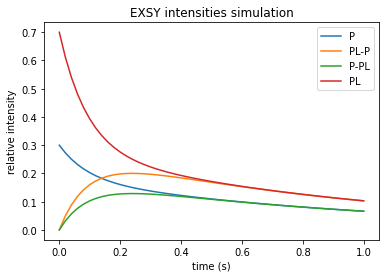

In [0]:
#make some data

kex = 10.0   # s^{-1}
kon = 4.0    # M * M^{-1}s^{-1} concentration times diffusion limited on rate
koff = kex - kon
R1P = 1.0    # s^{-1}
R1PL = R1P   # keep things simple for now
pa = 0.3     # P in model
pb = 1 - pa  # PL in model

IPzero = 1 * pa
IPLzero = 1 * pb

tStart = 0.0
tStop = 1.0        # Tmix up to about 1/R1
nTimes = 51
tval = np.linspace(tStart,tStop,nTimes) # to get a matching time axis for plotting
tmix = tval

#y = model(T_mix = tmix, R_1P = R1P, R_1PL = R1PL, k_on = kon, k_off = koff, I_P0 = IPzero, I_PL0 = IPLzero)
y = model(T_mix = tmix, R_1P = R1P, k_on = kon, k_off = koff, I_P0 = IPzero, I_PL0 = IPLzero)._asdict() # simple model with one R1

#print(y[0][:])

#plot the results
plt.title("EXSY intensities simulation")
plt.xlabel('time (s)')
plt.ylabel('relative intensity')
plt.plot(tval,y[IP], label='P')
plt.plot(tval,y[IPL_P], label='PL-P')
plt.plot(tval,y[IP_PL], label='P-PL')
plt.plot(tval,y[IPL], label='PL')
#plt.plot(tval,y[4], label='L1')
#plt.plot(tval,y[5], label='L2')
plt.legend()

This seems to work, but produces rather different results than the expm_multiply() version above. Perhaps the non-sparsity of the matrix A makes the matrix exponential method too inaccurate?



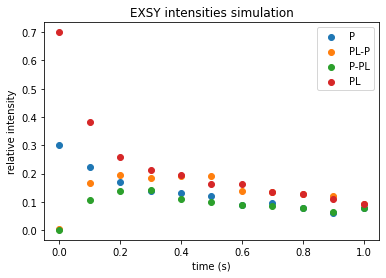

In [0]:
#simulate some data


kex = 10.0   # s^{-1}
kon = 4.0    # M * M^{-1}s^{-1} concentration times diffusion limited on rate
koff = kex - kon
R1P = 1.0    # s^{-1}
R1PL = R1P   # keep things simple for now
pa = 0.3
pb = 1 - pa

IPzero = 1 * pa
IPLzero = 1 * pb

tStart = 0.0
tStop = 1.0        # Tmix up to about 1/R1
nTimes = 11
tval = np.linspace(tStart,tStop,nTimes) # to get a matching time axis for plotting
tmix = tval

y_data = model(T_mix = tmix, R_1P = R1P, k_on = kon, k_off = koff, I_P0 = IPzero, I_PL0 = IPLzero)._asdict() # simple model with one R1

sigma_data = 0.01
np.random.seed(88)
for var in y_data:
    y_data[var] += np.random.normal(0, sigma_data, size=len(tmix))

#print(y_data)

#plot the results
plt.title("EXSY intensities simulation")
plt.xlabel('time (s)')
plt.ylabel('relative intensity')
plt.scatter(tval,y_data[IP], label='P')
plt.scatter(tval,y_data[IPL_P], label='PL-P')
plt.scatter(tval,y_data[IP_PL], label='P-PL')
plt.scatter(tval,y_data[IPL], label='PL')
plt.legend()


Now fit the simulated data and report the results and show the fit.

If the code returns an error make sure you have re-run the previous block to ensure that there are no incorrectly defined variables.


Parameter Value        Standard Deviation
I_P0      3.092612e-01 1.835072e-02
I_PL0     6.988738e-01 2.316031e-02
R_1P      1.020337e+00 8.562594e-02
k_off     6.298139e+00 7.486296e-01
k_on      4.182325e+00 5.088191e-01
Status message         Optimization terminated successfully.
Number of iterations   31
Objective              <symfit.core.objectives.LeastSquares object at 0x7f2ec948dc18>
Minimizer              <symfit.core.minimizers.BFGS object at 0x7f2ec948d470>

Goodness of fit qualifiers:
chi_squared            0.003531620696412519
objective_value        0.0017658103482062594
r_squared              0.9913396991049372


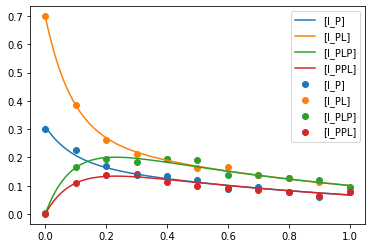

In [0]:
#fit

from symfit import Fit

#kon.min, kon.max = 0.01, 100
#koff.min, koff.max = 0.01, 100
#R1P.min, R1P.max = 0.1, 10
#IPzero.min, IPzero.max = 0.01, 1.5
#IPLzero.min, IPLzero.max = 0.01, 1.5

fit = Fit(model, T_mix = tmix, I_P=y_data[IP], I_PLP=y_data[IPL_P], I_PPL=y_data[IP_PL], I_PL=y_data[IPL])
fit_result = fit.execute()
print(fit_result)

taxis = np.linspace(tmix.min(), tmix.max(), 1000)
model_fit = model(T_mix=taxis, **fit_result.params)._asdict()
for var in y_data:
    plt.scatter(tmix, y_data[var], label='[{}]'.format(var.name))
    plt.plot(taxis, model_fit[var], label='[{}]'.format(var.name))
plt.legend()
plt.show()


Now build a multiple site (residue) model to generate multiple mock data varying R1P and the scale factor for IPzero and IPLzero

In [46]:
from symfit import parameters, variables, Variable, Parameter
from symfit import exp
from symfit import Model

#global parameters
kon, koff = parameters('k_on, k_off')

#time values themselves
tmix = Variable('T_mix')

resids = [1,2,3]
numResids = len(resids)
#create empty strings for creating the residue specific variables and parameters
r1ps = ''; r1pls = ''
ipzeros = ''; iplzeros = ''
ips = ''; ipls = ''; ippls = ''; iplps = ''
for i, resid in enumerate(resids):
    if i < (numResids-1):
        r1ps += 'R1P_{}'.format(resid) + ', '
        r1pls += 'R1PL_{}'.format(resid) + ', '
        ipzeros += 'IPzero_{}'.format(resid) + ', '
        iplzeros += 'IPLzero_{}'.format(resid) + ', '
        ips += 'IP_{}'.format(resid) + ', '
        ipls += 'IPL_{}'.format(resid) + ', '
        ippls += 'IPPL_{}'.format(resid) + ', '
        iplps += 'IPLP_{}'.format(resid) + ', '
    else:
        r1ps += 'R1P_{}'.format(resid)
        r1pls += 'R1PL_{}'.format(resid)
        ipzeros += 'IPzero_{}'.format(resid)
        iplzeros += 'IPLzero_{}'.format(resid)
        ips += 'IP_{}'.format(resid)
        ipls += 'IPL_{}'.format(resid)
        ippls += 'IPPL_{}'.format(resid)
        iplps += 'IPLP_{}'.format(resid)

#define the residue specific parameters and variables
R1Ps = parameters(r1ps)
R1PLs = parameters(r1pls)
IPzeros = parameters(ipzeros)
IPLzeros = parameters(iplzeros)
IPs = variables(ips)
IPLs = variables(ipls)
IPPLs = variables(ippls)
IPLPs = variables(iplps)

parsDict = dict(zip(resids,list(zip(R1Ps, R1PLs, IPzeros, IPLzeros, IPs, IPLs, IPPLs, IPLPs))))

#Palmer simple model (eqn 23)
pa = koff/(kon+koff)
pb = kon/(kon+koff)
kex = kon+koff

multi_model_dict = {}
temp_model_dict = {
    IP    : (IPzero  * (pa + pb * exp(-1*(kex)*tmix)) * exp(-1* R1P * tmix))
        for IP, IPzero, IPL, IPLzero, IPPL, IPLP, R1P in zip(IPs, IPzeros, IPLs, IPLzeros, IPPLs, IPLPs, R1Ps)}
multi_model_dict.update(temp_model_dict)
temp_model_dict = {
    IPL   : (IPLzero  * (pb + pa * exp(-1*(kex)*tmix)) * exp(-1* R1P * tmix))
        for IP, IPzero, IPL, IPLzero, IPPL, IPLP, R1P in zip(IPs, IPzeros, IPLs, IPLzeros, IPPLs, IPLPs, R1Ps)}
multi_model_dict.update(temp_model_dict)
temp_model_dict = {
    IPPL : (pa * (1 - exp(-1*(kex)*tmix)) * exp(-1* R1P * tmix) * IPzero)
        for IP, IPzero, IPL, IPLzero, IPPL, IPLP, R1P in zip(IPs, IPzeros, IPLs, IPLzeros, IPPLs, IPLPs, R1Ps)}
multi_model_dict.update(temp_model_dict)
temp_model_dict = {
    IPLP : (pb * (1 - exp(-1*(kex)*tmix)) * exp(-1* R1P * tmix) * IPLzero)
        for IP, IPzero, IPL, IPLzero, IPPL, IPLP, R1P in zip(IPs, IPzeros, IPLs, IPLzeros, IPPLs, IPLPs, R1Ps)}
multi_model_dict.update(temp_model_dict)

print(multi_model_dict)

model = Model(multi_model_dict)

{IP_1: IPzero_1*(k_off/(k_off + k_on) + k_on*exp(T_mix*(-k_off - k_on))/(k_off + k_on))*exp(-R1P_1*T_mix), IP_2: IPzero_2*(k_off/(k_off + k_on) + k_on*exp(T_mix*(-k_off - k_on))/(k_off + k_on))*exp(-R1P_2*T_mix), IP_3: IPzero_3*(k_off/(k_off + k_on) + k_on*exp(T_mix*(-k_off - k_on))/(k_off + k_on))*exp(-R1P_3*T_mix), IPL_1: IPLzero_1*(k_off*exp(T_mix*(-k_off - k_on))/(k_off + k_on) + k_on/(k_off + k_on))*exp(-R1P_1*T_mix), IPL_2: IPLzero_2*(k_off*exp(T_mix*(-k_off - k_on))/(k_off + k_on) + k_on/(k_off + k_on))*exp(-R1P_2*T_mix), IPL_3: IPLzero_3*(k_off*exp(T_mix*(-k_off - k_on))/(k_off + k_on) + k_on/(k_off + k_on))*exp(-R1P_3*T_mix), IPPL_1: IPzero_1*k_off*(1 - exp(T_mix*(-k_off - k_on)))*exp(-R1P_1*T_mix)/(k_off + k_on), IPPL_2: IPzero_2*k_off*(1 - exp(T_mix*(-k_off - k_on)))*exp(-R1P_2*T_mix)/(k_off + k_on), IPPL_3: IPzero_3*k_off*(1 - exp(T_mix*(-k_off - k_on)))*exp(-R1P_3*T_mix)/(k_off + k_on), IPLP_1: IPLzero_1*k_on*(1 - exp(T_mix*(-k_off - k_on)))*exp(-R1P_1*T_mix)/(k_off + k_on

In [0]:
#make some data

#global values
kex = 10.0   # s^{-1}
kon = 4.0    # M * M^{-1}s^{-1} concentration times diffusion limited on rate
koff = kex - kon
R1P = 1.0    # s^{-1}
R1PL = R1P   # keep things simple for now
pa = 0.3     # P in model
pb = 1 - pa  # PL in model

IPzero = 1 * pa
IPLzero = 1 * pb

tStart = 0.0
tStop = 1.0        # Tmix up to about 1/R1
nTimes = 51
tval = np.linspace(tStart,tStop,nTimes) # to get a matching time axis for plotting
tmix = tval

#y = model(T_mix = tmix, R_1P = R1P, R_1PL = R1PL, k_on = kon, k_off = koff, I_P0 = IPzero, I_PL0 = IPLzero)
y = model(T_mix = tmix, R_1P = R1P, k_on = kon, k_off = koff, I_P0 = IPzero, I_PL0 = IPLzero)._asdict() # simple model with one R1

#print(y[0][:])

#plot the results
plt.title("EXSY intensities simulation")
plt.xlabel('time (s)')
plt.ylabel('relative intensity')
plt.plot(tval,y[IP], label='P')
plt.plot(tval,y[IPL_P], label='PL-P')
plt.plot(tval,y[IP_PL], label='P-PL')
plt.plot(tval,y[IPL], label='PL')
#plt.plot(tval,y[4], label='L1')
#plt.plot(tval,y[5], label='L2')
plt.legend()

It would be nice to have a model with separate R1s for each site in each state and this should be possible with the fuller expansions provided by Palmer and Mittermaier.

Here's an attempt with the Mittermaier version since they haven't missed out the sqrt() in the paper.

In [0]:
#Back to the expanded solution to the matrix exponential as a symfit multicomponent model

from symfit import parameters, variables, symbols, Matrix, Variable, Parameter
from symfit import exp, sqrt
from symfit import Model

kon, koff, R1P, R1PL = parameters('k_on, k_off, R_1P, R_1PL')
#A = MatrixSymbol('A',[[kon + R1P , -1*koff],[-1*kon, koff + R1PL]])
IPzero, IPLzero = parameters('I_P0, I_PL0')
#yzero = Matrix([[IPzero, 0],[0, IPLzero]])
L1, L2 = variables('L1, L2')
IP, IPL, IP_PL, IPL_P = variables('I_P, I_PL, I_PPL, I_PLP')
#y = Matrix([[IP, IPL_P],[IP_PL, IPL]])
tmix = Variable('T_mix')

#Mittermaier
a11 = R1P + kon
a12 = -1*koff
a21 = -1*kon
a22 = R1PL + koff

lambda1 = (0.5 * (a11 + a22)) + sqrt((a11 + a22)**2 + (4 * kon * koff))
lambda2 = (0.5 * (a11 + a22)) - sqrt((a11 + a22)**2 + (4 * kon * koff))

l1expt = exp(-1 * lambda1 * tmix)
l2expt = exp(-1 * lambda2 * tmix)

#model_dict = {
#    IP    : IPzero  * (((a11 - lambda2) * l1expt) + ((lambda1 - a11)* l2expt)) / (lambda1 - lambda2),
#    IPL   : IPLzero * (((a22 - lambda2) * l1expt) + ((lambda1 - a22)* l2expt)) / (lambda1 - lambda2),
#    IP_PL : IPzero  * (((a21          ) * l1expt) - ((a21          )* l2expt)) / (lambda1 - lambda2),
#    IPL_P : IPzero  * (((a12          ) * l1expt) + ((a12          )* l2expt)) / (lambda1 - lambda2)
#}


model = Model(model_dict)

print(model)



In [0]:
#make some data

kex = 10.0   # s^{-1}
kon = 4.0    # M * M^{-1}s^{-1} concentration times diffusion limited on rate
koff = kex - kon
R1P = 1.0    # s^{-1}
R1PL = R1P   # keep things simple for now
pa = 0.3
pb = 1 - pa

IPzero = 1 * pa
IPLzero = 1 * pb

tStart = 0.0
tStop = 1.0        # Tmix up to about 1/R1
nTimes = 51
tval = np.linspace(tStart,tStop,nTimes) # to get a matching time axis for plotting
tmix = tval

y = model(T_mix = tmix, R_1P = R1P, R_1PL = R1PL, k_on = kon, k_off = koff, I_P0 = IPzero, I_PL0 = IPLzero)

#print(y[0][:])

#plot the results
plt.title("EXSY intensities simulation")
plt.xlabel('time (s)')
plt.ylabel('relative intensity')
plt.plot(tval,y[0], label='P')
plt.plot(tval,y[1], label='PL-P')
plt.plot(tval,y[2], label='P-PL')
plt.plot(tval,y[3], label='PL')
#plt.plot(tval,y[4], label='L1')
#plt.plot(tval,y[5], label='L2')
plt.legend()

## Three state model